In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import itertools
import keras
import keras.layers as layers
from keras.callbacks import EarlyStopping

import tensorflow as tf
import os
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [2]:
data = pd.read_csv("master_dataset/processed_data.csv")
# drop unwanted features


# Drop all the column , keep only class , overall_context

x = data['overall_content']
y = data['class'] 
    
# As we will be vectorizing the content and doing LSTM on it

print(x,y)

0        donald trump sends out embarrassing new year’s...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes an internet joke ...
3        trump is so obsessed he even has obama’s name ...
4        pope francis just called out donald trump duri...
                               ...                        
38653    'fully committed' nato backs new us approach a...
38654    lexisnexis withdrew two products chinese marke...
38655    minsk cultural hub becomes authorities in shad...
38656    vatican upbeat possibility pope francis visiti...
38657    indonesia buy $114 billion worth russian jets ...
Name: overall_content, Length: 38658, dtype: object 0        1
1        1
2        1
3        1
4        1
        ..
38653    0
38654    0
38655    0
38656    0
38657    0
Name: class, Length: 38658, dtype: int64


In [3]:
y.value_counts()

0    21196
1    17462
Name: class, dtype: int64

### Prepare the data

In [4]:
#first split the dataset into training and test sets


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 4222)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

#check that train set is balance
y_train.value_counts()

# Since the dataset is pretty balanced, Real - 55% and Fake - 45% of the data,
# By oversampling, we will have duplicates in the model which will overtrain out model.
# By undersampling, we might lose out on critical information.

0    12717
1    10477
Name: class, dtype: int64

In [5]:
# Find the number of maximum text 
lst = []
words = []
for item in x_train:
    lst.append(len(item.split()))

big_list = [item.split() for item in x_train]
flat_list = [item for sublist in big_list for item in sublist]
unique = list(set(flat_list))


In [6]:
print(len(unique)) # How many different words are there
print(max(lst)) # What the maximum word in an article 

207463
5130


(array([2.1596e+04, 1.4800e+03, 7.0000e+01, 2.4000e+01, 1.2000e+01,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000e+00, 5.1480e+02, 1.0276e+03, 1.5404e+03, 2.0532e+03,
        2.5660e+03, 3.0788e+03, 3.5916e+03, 4.1044e+03, 4.6172e+03,
        5.1300e+03]),
 <BarContainer object of 10 artists>)

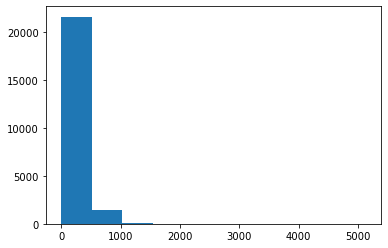

In [7]:
import matplotlib.pyplot as plt
plt.hist(lst)

In [8]:
# # Model constants / Parameters
max_features = 40000
embed_size = 100
maxlen = [500,1000]
dense_units = [64,128]
lstm_units = [64,128]

In [9]:
candidate_params = list(itertools.product(maxlen,dense_units,lstm_units))

In [10]:
candidate_params

[(500, 64, 64),
 (500, 64, 128),
 (500, 128, 64),
 (500, 128, 128),
 (1000, 64, 64),
 (1000, 64, 128),
 (1000, 128, 64),
 (1000, 128, 128)]

In [11]:
def tokenized_sets(maxlen):
    results = []
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(x_train.squeeze())

    tokenized_train = tokenizer.texts_to_sequences(x_train.squeeze())
    x_train_tokenized = pad_sequences(tokenized_train , maxlen=maxlen)
    results.append(x_train_tokenized)

    tokenized_val = tokenizer.texts_to_sequences(x_validation)
    x_validation_tokenized = pad_sequences(tokenized_val , maxlen=maxlen)
    results.append(x_validation_tokenized)

    tokenized_test = tokenizer.texts_to_sequences(x_test)
    x_test_tokenized = pad_sequences(tokenized_test , maxlen=maxlen)
    results.append(x_test_tokenized)

    return results

## Build A model

In [12]:
def lstm_model(lstm_units, dense_units):
    model = keras.models.Sequential()
    model.add(layers.Embedding(max_features,embed_size))
    model.add(layers.Dropout(0.5))

    model.add(layers.LSTM(lstm_units, return_sequences=True))
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid",name="predictions"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

    
    return model

In [13]:
epochs = 3

early_stopping = EarlyStopping()

def make_predictions(tokenized_text, model):
    model.fit(tokenized_text[0], y_train,
                  validation_data = (tokenized_text[1], y_validation),
                  epochs = epochs,
                  callbacks = [early_stopping])
    y_pred = (model.predict(tokenized_text[2]) >= 0.5).astype("int")
    return y_pred

## Train and evalute the model

In [14]:
for parameters in candidate_params:
    count = 1
    accuracy = 0
    best_params = []
    data = tokenized_sets(parameters[0])
    lstm = lstm_model(parameters[1], parameters[2])
    predictions = make_predictions(data, lstm)
    accuracy_current = metrics.accuracy_score(y_test, predictions)
    if accuracy_current > accuracy:
        accuracy = accuracy_current
        best_params = parameters 
print(best_params)

Epoch 1/3
725/725 [==============================] - 246s 337ms/step - loss: 0.1486 - accuracy: 0.9349 - val_loss: 0.0200 - val_accuracy: 0.9933
Epoch 2/3
242/242 [==============================] - 21s 87ms/step
Epoch 1/3
725/725 [==============================] - 277s 378ms/step - loss: 0.1164 - accuracy: 0.9480 - val_loss: 0.0206 - val_accuracy: 0.9934
Epoch 2/3
725/725 [==============================] - 270s 372ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0163 - val_accuracy: 0.9939
Epoch 3/3
242/242 [==============================] - 24s 97ms/step
Epoch 1/3
725/725 [==============================] - 429s 589ms/step - loss: 0.1757 - accuracy: 0.9166 - val_loss: 0.0380 - val_accuracy: 0.9863
Epoch 2/3
725/725 [==============================] - 420s 580ms/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.0188 - val_accuracy: 0.9952
Epoch 3/3
242/242 [==============================] - 45s 183ms/step
Epoch 1/3
725/725 [==============================] - 476s 654ms/step - lo

### Analysis after Training Model

In [16]:
final_sets = tokenized_sets(best_params[0])
final_lstm_model = lstm_model(best_params[1], best_params[2])

history = final_lstm_model.fit(final_sets[0], y_train,
                              validation_data = (final_sets[1], y_validation),
                              epochs = epochs, 
                              callbacks = [early_stopping])
y_pred = (final_lstm_model.predict(final_sets[2]) >= 0.5).astype("int")

Epoch 1/3
725/725 [==============================] - 1044s 1s/step - loss: 0.1325 - accuracy: 0.9430 - val_loss: 0.0127 - val_accuracy: 0.9961
Epoch 2/3
242/242 [==============================] - 86s 353ms/step


In [17]:
print("Performance on Test set:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1_score:", metrics.f1_score(y_test, y_pred))

Performance on Test set:
Accuracy: 0.9940506983962752
Precision: 0.9991321955452704
Recall: 0.9877037460680583
F1_score: 0.9933851020995111
